# Report

Summary your findings and motivate your choice of approach. A better motivation show your understanding of the lab. Dont forget to include the result from part 1!

**Name:** Jan Dalheimer
**Date:** 2022-11-04

## Introduction

An interesting albeit somewhat frustrating lab. I had quite some issues with reading of images and channel order, as I understand it PyTorch Conv2d layers expect the channel order `[batch, channel, width, height]` however the code produced the order `[batch, width, height, channel]`. Weirdly however, when reordering the channels in the dataset the torchvision Resize transform resized the data on the first two dimensions (before batching, so on `channel` and `width`) which obviously is wrong. In the end I switched from `imageio` to `Pillow` for reading the image, which is what is used in most PyTorch documentation and examples, and seemed to solve this issue.

In general, my approach was:

1. Run the code
2. Inspect the result on tensorboard
3. Adjust
4. Repeat

I never managed to train past the first epoch without overfitting, despite reducing the learning rate, adding data augmentation, weight decay and the pre-existing dropout layer.

## Result

### Question 1

```python
train_dataset = FlyingObjects(training_img_dir, transform=train_transform)
valid_dataset = FlyingObjects(validation_img_dir, transform=test_transform)
test_dataset = FlyingObjects(testing_img_dir, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

features, labels = next(iter(train_loader))
image_with_labels(np.transpose(features[:10], (0, 2, 3, 1)), [train_dataset.classes[l] for l in labels[:10]])
```

### Question 2

```python
# from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-with-tensorboard-and-pytorch-3344ad5e7209
def createConfusionMatrix(net, loader):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for inputs, labels in loader:
        output = net(inputs)  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth

    # constant for classes
    classes = train_dataset.classes[:-1]

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=[i for i in classes],
                         columns=[i for i in classes])
    plt.figure(figsize=(12, 7))    
    return sn.heatmap(df_cm, annot=True).get_figure()

def train(epoch_number, optimizer, loss, model, train_loader, valid_loader=None, lr=0.001):
    writer = SummaryWriter()
    
    opt = optimizer(model.parameters(), lr=lr, weight_decay=1e-5)
    for epoch in range(epoch_number):
        step = (epoch + 1) * len(train_loader) - 1
        
        model.train()
        train_loss = 0
        train_correct = 0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            opt.zero_grad()
            outputs = model(inputs)
            l = loss(outputs, labels)
            l.backward()
            opt.step()
            writer.add_scalar("Loss/batch", l, epoch*len(train_loader) + batch_idx)
            train_loss += l.item()
            train_correct += torch.sum(torch.max(outputs, 1).indices == labels).item()
            if (batch_idx % 10) == 0:
                print("\r[Batch {} of Epoch {}]\t Loss:{}".format(batch_idx, epoch, l), end="")
        train_loss /= len(train_loader)
        train_correct /= len(train_loader)
        writer.add_scalar("Loss/train", train_loss, step)
        writer.add_scalar("Accuracy/train", train_correct, step)
        writer.add_figure("CF/train", createConfusionMatrix(model, train_loader), step)
                
        if valid_loader:
            valid_loss = 0
            valid_correct = 0
            predictions = []
            truth = []
            model.eval()
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                predictions.extend((torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy())
                truth.extend(labels.data.cpu().numpy())
                l = loss(outputs, labels)
                valid_loss += l.item()
                valid_correct += torch.sum(torch.max(outputs, 1).indices == labels).item()
            valid_loss /= len(valid_loader)
            valid_correct /= len(valid_loader)
            writer.add_scalar("Loss/valid", valid_loss, step)
            writer.add_scalar("Accuracy/valid", valid_correct, step)
            writer.add_figure("CF/valid", createConfusionMatrix(model, valid_loader), step)
    writer.add_graph(model, next(iter(train_loader))[0])

def predict(model, loader):
    model.eval()
    predicted, truth = [], []
    for inputs, labels in loader:
        outputs = model(inputs)
        predicted.extend(outputs.numpy())
        truth.extend(outputs.numpy())
    return predicted, truth
```

### Question 3

As mentioned, the network started overfitting very early. This run is with weight decay and a lowered learning rate:

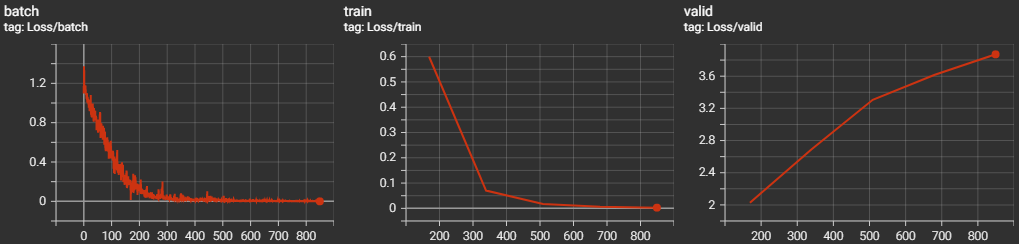

I also added logging of accuracy (defined as the percentage of correctly classified instances), which I find easier to interpret than the somewhat abstract "loss":

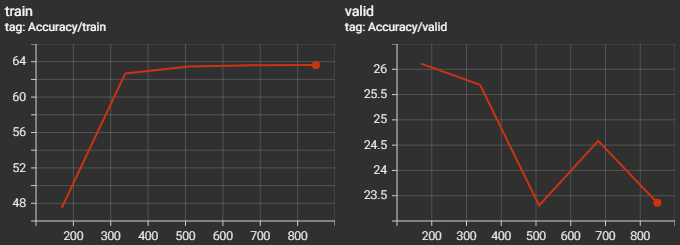

As well as logging of the confusion matrix (left is training data, right is validation data):

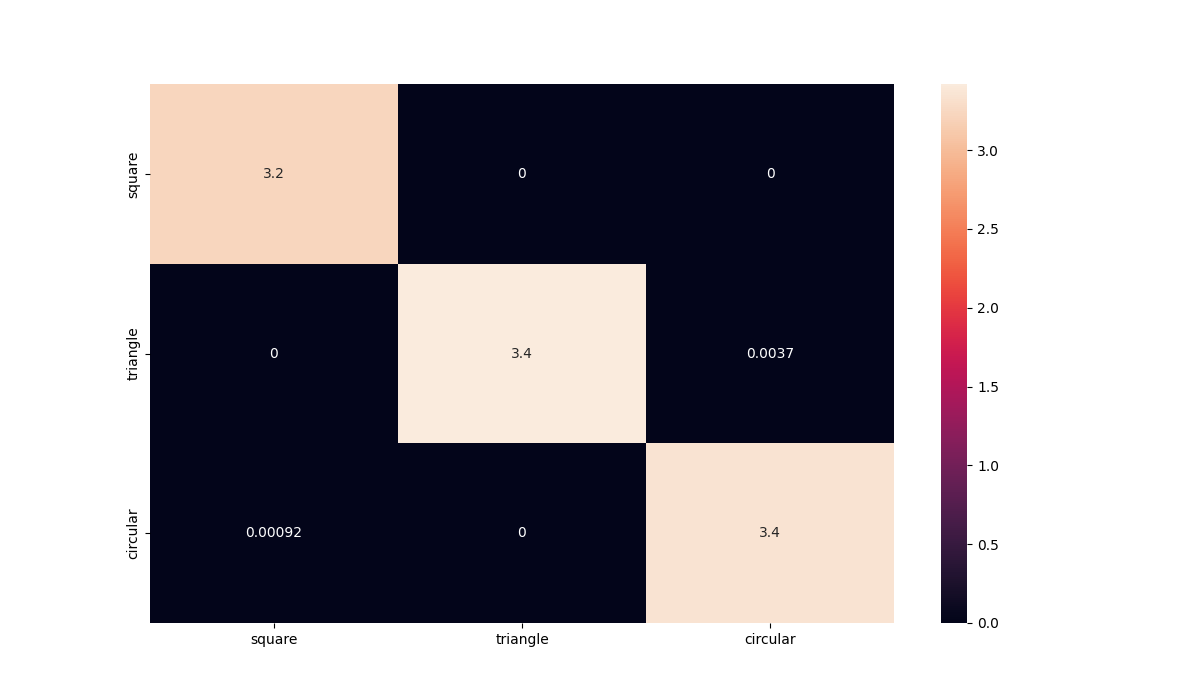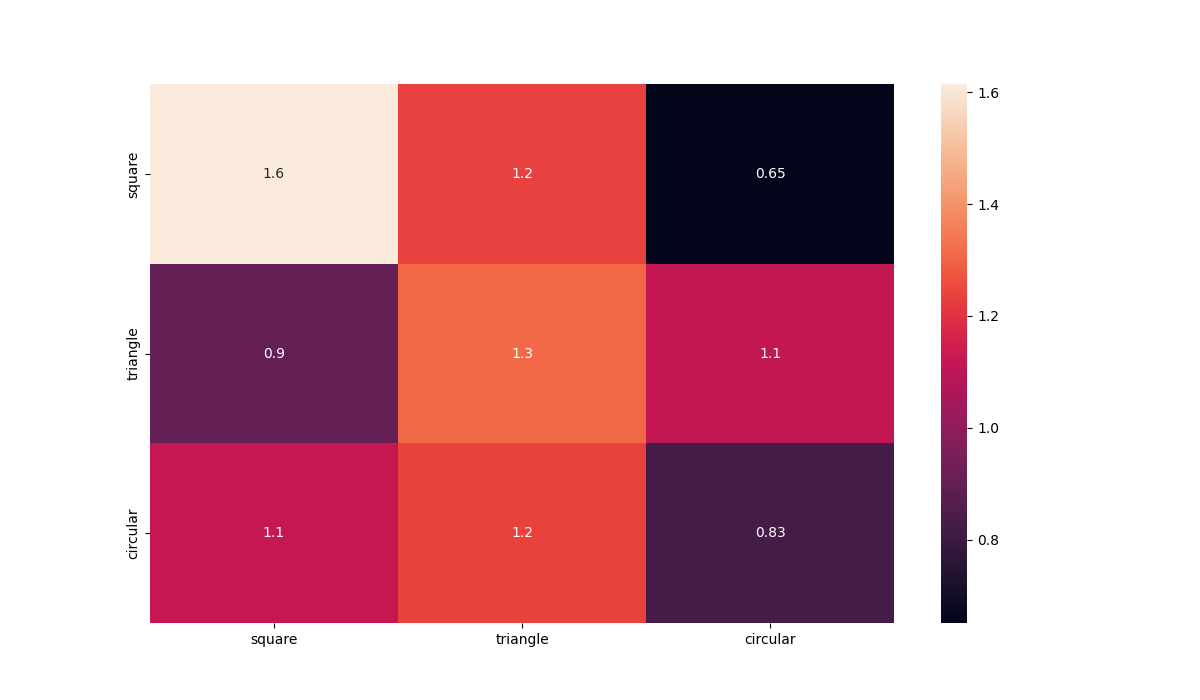

### Question 4

I first just added `RandomVerticalFlip` and `RandomHorizontalFlip` to the existing transform chains. I however later realized that this approach only altered the existing data without generating any new data. So for question 5 I changed this to perform the augmentation in the dataset.

I did not consider other types of augmentations; they seemed to me to broadly fall into two categories, adjustments like contrast and jitter or cropping. Adjustments didn't feel useful for a dataset of "pure" colors (as opposed to images with various noise) and I didn't want to risk cropping away a crucial part of the image, since our "object of interest" is in just a small part of the image.

The result was somewhat better (red line is without augmentation, blue is with) though still not great:

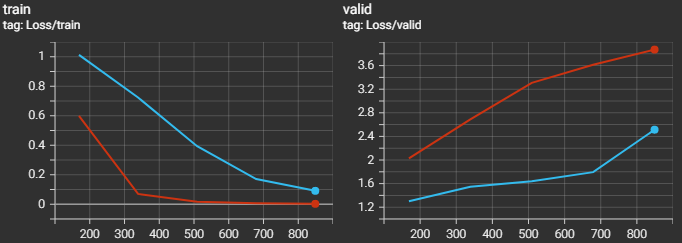

In the confusion matrix for the validation data we can see a clear trend however:

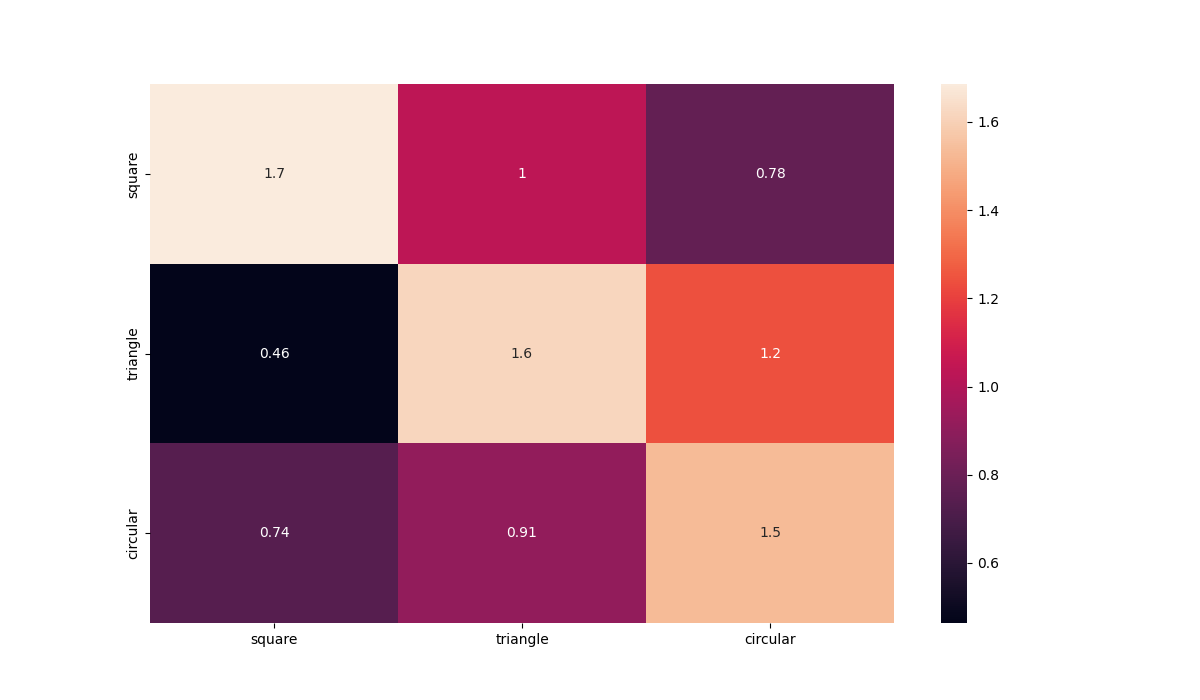

### Question 5

Weirdly, the result was worse than in the previous try. It is clear that augmentation is better than no augmentation, yet 128x128 augmented did worse than 64x64 augmented, while I would have assumed that the higher resolution always would have given a better result thanks to sharper boundaries (red is 64x64, blue is augmented 64x64, pink is 128x128, green is augmented 128x128):

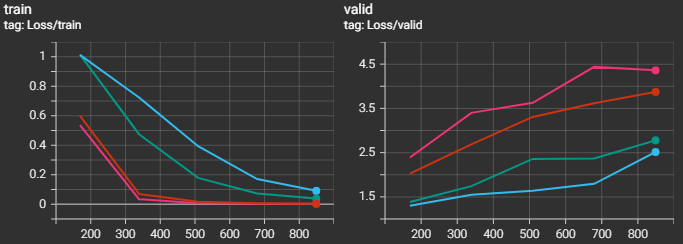

At this point I realized the issue with the previous augmentation code only randomly adjusting the existing data while I wanted more data, so I modified the dataset to allow it to produce additional augmented data. The result was in the same ballpark, no significant improvement and still worse than 64x64 (same colors as above, additionally gray is 128x128 with "real augmentation"):

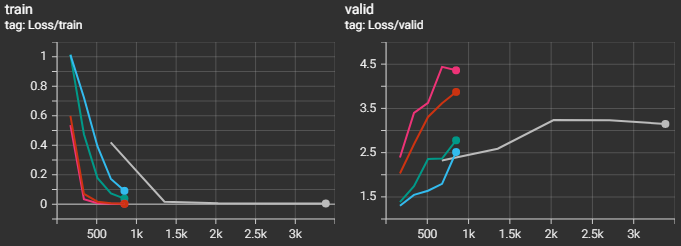

Note the additional steps in the gray line, since we get more batches for each epoch now.

### Question 6

As expected, the result was somewhat worse (gray is corse, blue is fine):

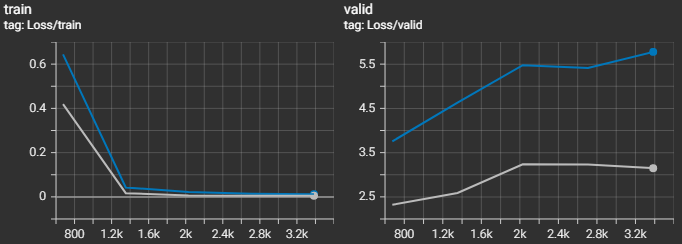

Previously, the network could have ignored all colored shapes and just focus on the black shapes to get the right answer. Now, the network must recognize the black shape and the color of the corresponding colored shape, which obviously is a more complex problem.

Interestingly, looking at the confusion matrix for the validation data one can recognize that there is a slight tendency to a line in the middle was we want, but also another line in parallell to it:

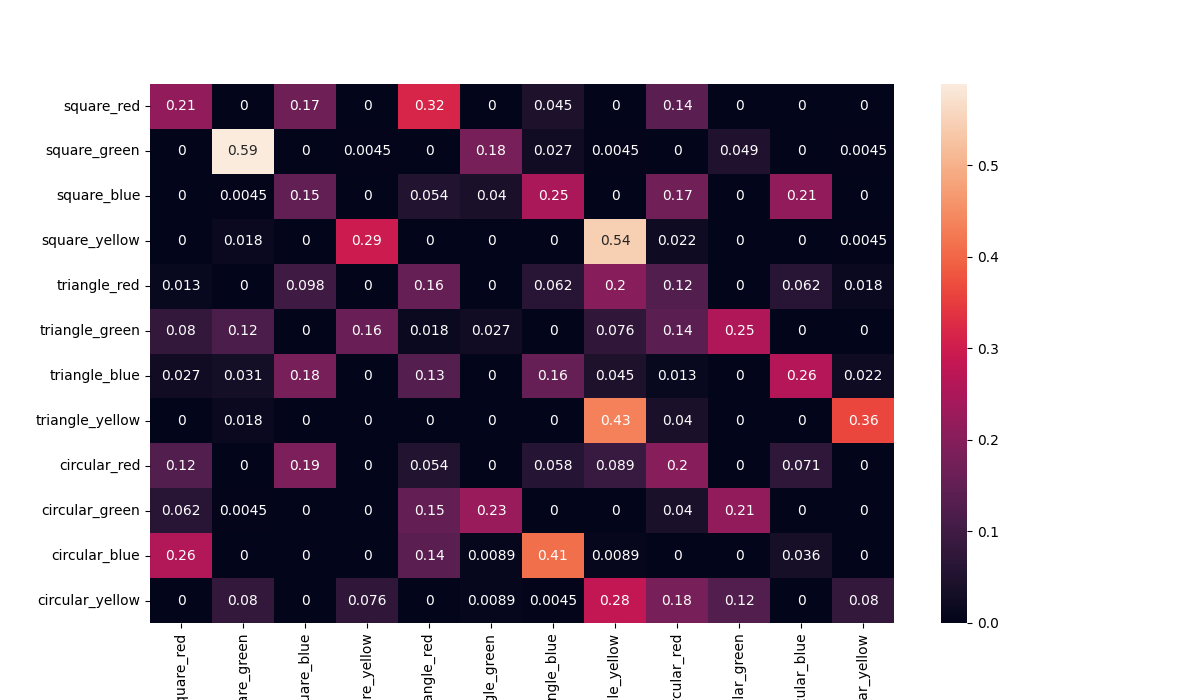

This indicates that the network is commonly mixing up squares and triangles while managing to pick the correct color.